# Bibliotecas

In [1]:
import numpy as np
import pandas as pd

In [2]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go 

In [3]:
import matplotlib.pyplot as plt

In [4]:
import scipy.stats

# DIRECCIONES 

### DIRECCIÓN DE CARPETA DATOS SCRIPT DESCARGA EELabs

Indicar carpeta ubicación de la carpeta Datos_fotometros creada por el script de descarga de los datos de los fotómetros de EELabs

In [5]:
INPUT=r'C:\Users\borja\OneDrive\Escritorio\Trabajo\EELabs\Datos_CSVs\Articulo\Photometer_data'

### DIRECCIÓN DE GUARDADO DE LOS DATOS DE LAS FIGUARAS

Poner la carpeta donde se quieran guardar las figuras

In [6]:
output=r'C:\Users\borja\OneDrive\Escritorio\Trabajo\EELabs\Datos_CSVs\Articulo\Figuras'

# Lectura de datos y preprocesamiento

Lectura de datos, poner la correspondiente dirección

In [7]:
Photometers_records=pd.DataFrame()
for i in range(1,4):
    A=pd.read_csv(INPUT+'\Records\Records_'+str(i)+'.csv')
    Photometers_records=pd.concat([Photometers_records,A])

In [8]:
Fotometros=pd.read_csv(INPUT+'\All_devices.csv')
Fotometros=Fotometros.drop_duplicates()

Numero de fotómetros con datos

In [9]:
len(set(Photometers_records['name']))

504

Descartar datos con presencia de luna o nubes

In [10]:
data=Photometers_records[(Photometers_records['clouds']==False) & (Photometers_records['moon']==False)]

Obtiene las medianas diarias con los filtros de galaxia y zodical aplicados. **data_2 corresponde a los datos sin filtrar ni galaxia ni zodiacal**

In [11]:
data_2=data
q=data_2[(data_2['galaxy']==False) & (data_2['zodiacal']==False)].groupby(['name']).median()[['mag']]
data_2=data_2.merge(q,left_on='name',right_on='name')
f=list(q.sort_values(['mag']).index)
nc=list(data_2.columns)
nc[1]='mag'
nc[-1]='P50_all_filter'
data_2.columns=nc

C:\Users\borja\AppData\Local\Temp\ipykernel_19596\1518626055.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  q=data_2[(data_2['galaxy']==False) & (data_2['zodiacal']==False)].groupby(['name']).median()[['mag']]


In [12]:
data_2

,time,mag,name,moon,clouds,galaxy,zodiacal,sigma,P50_all_filter
0,2022-01-01 19:08:45.792225860+00:00,17.84,stars52,False,False,True,True,False,18.66
1,2022-01-01 19:09:15.784006291+00:00,17.83,stars52,False,False,True,True,False,18.66
2,2022-01-01 19:09:45.805173150+00:00,17.84,stars52,False,False,True,True,False,18.66
3,2022-01-01 19:10:15.854654512+00:00,17.83,stars52,False,False,True,True,False,18.66
4,2022-01-01 19:10:45.892778091+00:00,17.83,stars52,False,False,True,True,False,18.66
...,...,...,...,...,...,...,...,...,...
4458391,2022-12-31 06:03:29.526203264+00:00,21.08,stars288,False,False,False,True,False,21.22
4458392,2022-12-31 06:04:29.623642434+00:00,21.07,stars288,False,False,False,True,False,21.22
4458393,2022-12-31 06:05:29.681904232+00:00,21.07,stars288,False,False,False,True,False,21.22
4458394,2022-12-31 06:06:29.744373982+00:00,21.07,stars288,False,False,False,True,False,21.22


Generamos los datos filtrados por galxia y zodiacal en zonas solo brillantes. **data_3 corresponde a los datos filtrados galaxia y zodiacal, solo zonas brillantes**

In [13]:
data_3=data_2[((data_2['galaxy']==False) & (data_2['zodiacal']==False) & (data_2['P50_all_filter']>20)) | (data_2['P50_all_filter']<=20)]

Generamos los datos filtrados por galxia y zodiacal para todos. **data_4 corresponde a los datos filtrados galaxia y zodiacal de forma general**

In [14]:
data_4=data_2[(data_2['galaxy']==False) & (data_2['zodiacal']==False)]

# Número datos

La siguiente función realiza el bootstraping para obtener las incertidumbres del rango intercuartílico, la media y la mediana según el tamaño de la muesta

In [15]:
def Bootstraping(data,n_muestras,tamaño_muestras):
    E_RIC=[]
    E_MEDIAN=[]
    E_MEDIA=[]
    for n in tamaño_muestras:
        RIC=[]
        MEDIAN=[]
        MEDIA=[]
        for i in range(0,n_muestras):
            submuestra2=data.sample(n,replace=True)
            RIC=RIC+[submuestra2.quantile(.75)-submuestra2.quantile(.25)]
            MEDIAN=MEDIAN+[submuestra2.median()]
            MEDIA=MEDIA+[submuestra2.mean()]
        Fram1=pd.DataFrame(RIC)
        E=Fram1.quantile(.975)[0]-Fram1.quantile(.025)[0]
        Fram2=pd.DataFrame(MEDIAN)
        E2=Fram2.quantile(.975)[0]-Fram2.quantile(.025)[0]
        Fram3=pd.DataFrame(MEDIA)
        E3=Fram3.quantile(.975)[0]-Fram3.quantile(.025)[0]
        E_RIC=E_RIC+[E]
        E_MEDIAN=E_MEDIAN+[E2]
        E_MEDIA=E_MEDIA+[E3]
    return E_RIC,E_MEDIAN,E_MEDIA

Función que le das un vector de vectores y los hace todos de la misma longitud

In [16]:
def Igualar_longitud(V):
    V=[list(i) for i in V]
    v1=[len(i) for i in V]
    print(v1)
    W=[]
    for j in V:
        W=W+[j+(max(v1)-len(j))*[None]]
    v2=[len(i) for i in W]
    return W

Muestra de fotómetros sobre los que se aplica el bootstriping, se han elegido con buenos parámetros y gran cantidad de datos

In [17]:
Fotometros_N=['stars495','stars202','stars1','stars550','LPL1_050','LPL2_104','LPL3_104','LPL3_110']

Función que obtiene la evolcuión de la incertidumbre según el tamaño de la muestra

In [18]:
def Evolucion_intertidumbres():
    X=np.arange(100, 3000, 10)
    RIC=[]
    MEDIAN=[]
    for i in Fotometros_N:
        Boot=Bootstraping(data_4[data_4['name']==i]['mag'],10,X)
        RIC=RIC+[Boot[0]]
        MEDIAN=MEDIAN+[Boot[1]]
    RIC=Igualar_longitud(RIC)
    MEDIAN=Igualar_longitud(MEDIAN)
    return RIC, MEDIAN

In [19]:
Ev=Evolucion_intertidumbres()

[290, 290, 290, 290, 290, 290, 290, 290]
[290, 290, 290, 290, 290, 290, 290, 290]


Grafico para el caso del RIC

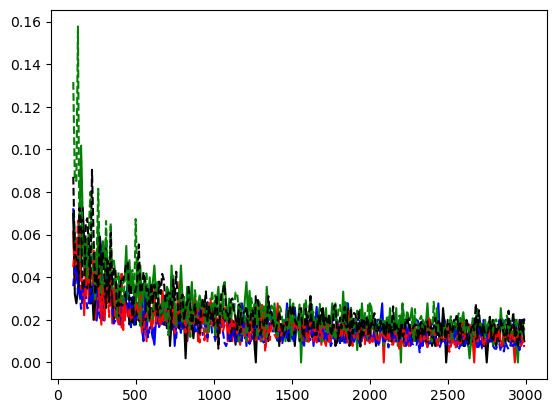

In [20]:
X=np.arange(100, 3000, 10)
X2=np.arange(100, 1000, 10)
COLOR=['blue','red','green','black','blue','red','green','black']
LINESTYLE=['-']*4+['--']*4
for i in range(0,8):
    plt.plot(X,Ev[0][i],color=COLOR[i],linestyle=LINESTYLE[i])

Grafico para el caso de las medians

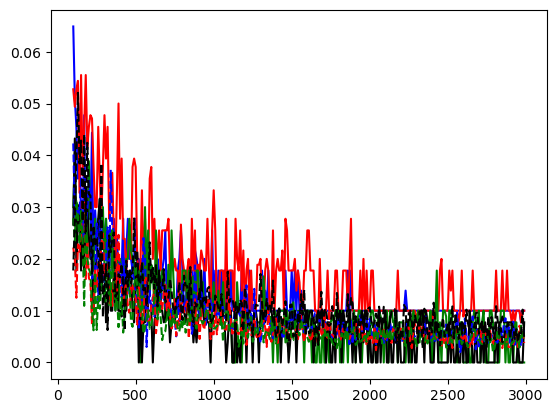

In [21]:
for i in range(0,8):
    plt.plot(X,Ev[1][i],color=COLOR[i],linestyle=LINESTYLE[i])

Guardar para graficar el ICR 

In [22]:
dict1=dict()
for i in range(0,len(Fotometros_N)):
    dict1.update({Fotometros_N[i]:Ev[0][i]})
guardar=pd.DataFrame(dict1)
guardar.to_csv(output+'\Figura_3a.csv',index=False)

Guardar para graficar las medianas

In [23]:
dict1=dict()
for i in range(0,len(Fotometros_N)):
    dict1.update({Fotometros_N[i]:Ev[1][i]})
guardar=pd.DataFrame(dict1)
guardar.to_csv(output+'\Figura_3b.csv',index=False)

#  Cálculo de variables por fotómetro

## Filtro de galaxia y zodaical estricto

En base a los datos con filtrado de galaxia y zodicala estricto

In [24]:
f1=data_4[['name','mag']].groupby(['name']).std()['mag']
f2=data_4[['name','mag']].groupby(['name']).mean()['mag']
D=data_4[['name','mag','P50_all_filter']].merge(f1,left_on='name',right_on='name')
D=D.merge(f2,left_on='name',right_on='name')
D.columns=['name','mag','P50_all_filter','STD','M']
D=D[(D['mag']<D['P50_all_filter']+D['STD']*3) & (D['mag']>D['P50_all_filter']+D['STD']*-3)]

In [25]:
N_ex=pd.DataFrame(data_4[['name','mag']].groupby(['name']).quantile(.75)['mag'])
N_ex=N_ex.merge(data_4[['name','mag']].groupby(['name']).quantile(.25)['mag'],right_on='name',left_on='name')
N_ex.columns=['P75','P25']
N_ex=data_4.groupby(['name']).median()[['mag']].merge(N_ex,right_on='name',left_on='name')
N_ex=N_ex.merge(D[['name','mag']].groupby(['name']).std()[['mag']],left_on='name',right_on='name')
N_ex=data_4.groupby(['name']).count()[['mag']].merge(N_ex,right_on='name',left_on='name')
N_ex.columns=['N','P50','P75','P25','STD']
N_ex['P75-P25']=N_ex['P75']-N_ex['P25']
N_ex['Asimetria']=(N_ex['P75']+N_ex['P25']-2*N_ex['P50'])/N_ex['P75-P25']
N_ex=N_ex[['N','P50','P75-P25','STD','Asimetria']]
N_ex=N_ex.merge(Fotometros[['name','TYPE']],left_on='name',right_on='name')

C:\Users\borja\AppData\Local\Temp\ipykernel_19596\329552066.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_ex=data_4.groupby(['name']).median()[['mag']].merge(N_ex,right_on='name',left_on='name')


Fotómetros de la Tabla 2

In [26]:
N_ex[N_ex['name'].isin(['LPL1_050','LPL2_104','LPL3_104','LPL3_110','stars1','stars202','stars495','stars550'])]

,name,N,P50,P75-P25,STD,Asimetria,TYPE
44,LPL1_050,1608,21.283,0.15400,0.117000,0.090909,SG
61,LPL2_104,1506,21.514,0.13975,0.113064,0.016100,SG
68,LPL3_104,1365,20.618,0.15400,0.357432,-0.168831,SG
70,LPL3_110,1562,20.778,0.16075,0.266963,-0.066874,SG
126,stars1,7557,18.370,0.16000,0.201296,-0.250000,TESS-W
133,stars202,5663,21.460,0.18000,0.117199,0.000000,TESS-W
236,stars495,5948,21.170,0.18000,0.115123,0.000000,TESS-W
254,stars550,20468,18.860,0.11000,0.130047,-0.090909,TESS-W


In [27]:
Cantidad=N_ex[(N_ex['TYPE']=='TESS-W') & (N_ex['P50']>=21)].count()[0],N_ex[(N_ex['TYPE']=='TESS-W') & (N_ex['P50']<21)].count()[0],N_ex[(N_ex['TYPE']=='SG') & (N_ex['P50']>=21)].count()[0],N_ex[(N_ex['TYPE']=='SG') & (N_ex['P50']<21)].count()[0]
print('Cantidades de fotometros sin filtrar por número: ')
print('TESS (>21 mag): '+str(Cantidad[0])+ ' fotometros')
print('TESS (<21 mag): '+str(Cantidad[1])+ ' fotometros')
print('SG (>21 mag): '+str(Cantidad[2])+ ' fotometros')
print('SG (<21 mag): '+str(Cantidad[3])+ ' fotometros')

Cantidades de fotometros sin filtrar por número: 
TESS (>21 mag): 108 fotometros
TESS (<21 mag): 95 fotometros
SG (>21 mag): 69 fotometros
SG (<21 mag): 57 fotometros


In [28]:
Cantidad500=N_ex[(N_ex['N']>500) & (N_ex['TYPE']=='TESS-W') & (N_ex['P50']>=21)].count()[0],N_ex[(N_ex['N']>500) & (N_ex['TYPE']=='TESS-W') & (N_ex['P50']<21)].count()[0],N_ex[(N_ex['N']>500) & (N_ex['TYPE']=='SG') & (N_ex['P50']>=21)].count()[0],N_ex[(N_ex['N']>500) & (N_ex['TYPE']=='SG') & (N_ex['P50']<21)].count()[0]
print('Cantidades de fotometros filtrado por número (N>500): ')
print('TESS (>21 mag): '+str(Cantidad500[0])+ ' fotometros')
print('TESS (<21 mag): '+str(Cantidad500[1])+ ' fotometros')
print('SG (>21 mag): '+str(Cantidad500[2])+ ' fotometros')
print('SG (<21 mag): '+str(Cantidad500[3])+ ' fotometros')

Cantidades de fotometros filtrado por número (N>500): 
TESS (>21 mag): 91 fotometros
TESS (<21 mag): 77 fotometros
SG (>21 mag): 44 fotometros
SG (<21 mag): 28 fotometros


In [29]:
porcentaje_perdida_TESS=round(sum(np.array(Cantidad)[:2]-np.array(Cantidad500)[:2])/sum(np.array(Cantidad)[:2])*100,2)
print('Porcentaje de pérdida TESS al filtrar por número: '+str(porcentaje_perdida_TESS)+' %')

Porcentaje de pérdida TESS al filtrar por número: 17.24 %


In [30]:
porcentaje_perdida_SG=round(sum(np.array(Cantidad)[2:]-np.array(Cantidad500)[2:])/sum(np.array(Cantidad)[2:])*100,2)
print('Porcentaje de pérdida SG al filtrar por número: '+str(porcentaje_perdida_SG)+' %')

Porcentaje de pérdida SG al filtrar por número: 42.86 %


Fotómetros filtrados por número en caso de filtro estricto

In [31]:
Menores500_pre=set(N_ex[(N_ex['N']<=500)]['name'].values)

## Filtro de galaxia y zodaical solo zonas más oscuras

In [32]:
f1=data_3[['name','mag']].groupby(['name']).std()['mag']
f2=data_3[['name','mag']].groupby(['name']).mean()['mag']
D=data_3[['name','mag','P50_all_filter']].merge(f1,left_on='name',right_on='name')
D=D.merge(f2,left_on='name',right_on='name')
D.columns=['name','mag','P50_all_filter','STD','M']
#D['RIC']=D['Q3']-D['Q1']
D=D[(D['mag']<D['P50_all_filter']+D['STD']*3) & (D['mag']>D['P50_all_filter']+D['STD']*-3)]

In [33]:
N_ex_F=pd.DataFrame(data_3[['name','mag']].groupby(['name']).quantile(.75)['mag'])
N_ex_F=N_ex_F.merge(data_3[['name','mag']].groupby(['name']).quantile(.25)['mag'],right_on='name',left_on='name')
N_ex_F.columns=['P75','P25']
N_ex_F=data_3.groupby(['name']).median()[['mag']].merge(N_ex_F,right_on='name',left_on='name')
N_ex_F=N_ex_F.merge(D[['name','mag']].groupby(['name']).std()[['mag']],left_on='name',right_on='name')
N_ex_F=data_3.groupby(['name']).count()[['mag']].merge(N_ex_F,right_on='name',left_on='name')
N_ex_F.columns=['N','P50','P75','P25','STD']
N_ex_F['P75-P25']=N_ex_F['P75']-N_ex_F['P25']
N_ex_F['Asimetria']=(N_ex_F['P75']+N_ex_F['P25']-2*N_ex_F['P50'])/N_ex_F['P75-P25']
N_ex_F=N_ex_F[['N','P50','P75-P25','STD','Asimetria']]
N_ex_F=N_ex_F.merge(Fotometros[['name','TYPE']],left_on='name',right_on='name')

C:\Users\borja\AppData\Local\Temp\ipykernel_19596\3768621760.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_ex_F=data_3.groupby(['name']).median()[['mag']].merge(N_ex_F,right_on='name',left_on='name')


In [34]:
Cantidad=N_ex_F[(N_ex_F['TYPE']=='TESS-W') & (N_ex_F['P50']>=21)].count()[0],N_ex_F[(N_ex_F['TYPE']=='TESS-W') & (N_ex_F['P50']<21)].count()[0],N_ex_F[(N_ex_F['TYPE']=='SG') & (N_ex_F['P50']>=21)].count()[0],N_ex_F[(N_ex_F['TYPE']=='SG') & (N_ex_F['P50']<21)].count()[0]
print('Cantidades de fotometros sin filtrar por número: ')
print('TESS (>21 mag): '+str(Cantidad[0])+ ' fotometros')
print('TESS (<21 mag): '+str(Cantidad[1])+ ' fotometros')
print('SG (>21 mag): '+str(Cantidad[2])+ ' fotometros')
print('SG (<21 mag): '+str(Cantidad[3])+ ' fotometros')

Cantidades de fotometros sin filtrar por número: 
TESS (>21 mag): 109 fotometros
TESS (<21 mag): 94 fotometros
SG (>21 mag): 71 fotometros
SG (<21 mag): 55 fotometros


In [35]:
Cantidad500=N_ex_F[(N_ex_F['N']>500) & (N_ex_F['TYPE']=='TESS-W') & (N_ex_F['P50']>=21)].count()[0],N_ex_F[(N_ex_F['N']>500) & (N_ex_F['TYPE']=='TESS-W') & (N_ex_F['P50']<21)].count()[0],N_ex_F[(N_ex_F['N']>500) & (N_ex_F['TYPE']=='SG') & (N_ex_F['P50']>=21)].count()[0],N_ex_F[(N_ex_F['N']>500) & (N_ex_F['TYPE']=='SG') & (N_ex_F['P50']<21)].count()[0]
print('Cantidades de fotometros filtrado por número (N>500): ')
print('TESS (>21 mag): '+str(Cantidad500[0])+ ' fotometros')
print('TESS (<21 mag): '+str(Cantidad500[1])+ ' fotometros')
print('SG (>21 mag): '+str(Cantidad500[2])+ ' fotometros')
print('SG (<21 mag): '+str(Cantidad500[3])+ ' fotometros')

Cantidades de fotometros filtrado por número (N>500): 
TESS (>21 mag): 92 fotometros
TESS (<21 mag): 84 fotometros
SG (>21 mag): 46 fotometros
SG (<21 mag): 33 fotometros


Fotómetros filtrados por número en caso de filtro zonas más oscuras

In [36]:
Menores500=set(N_ex_F[(N_ex_F['N']<=500)]['name'].values)

# Comportamiento promedio fotómetros

Funcion para obtener la distrbución promedia de los fotómetros

In [37]:
def Dis_pro(data):
    cont=1
    list_fot=set(data['name'].values)
    for i in list(list_fot):
        mediana=data[(data['name']==i)].median(numeric_only=True)['mag']
        a1=data[(data['name']==i)]['mag']-mediana
        if cont>1:
            aa=list(a1.values)+aa
        else:
            aa=list(a1.values)
        cont=cont+1
    return aa    

## Con outliers

In [38]:
data_3=data_3[~data_3['name'].isin(Menores500)]

In [39]:
aa=Dis_pro(data_3[(data_3['P50_all_filter']>21) & (data_3['P50_all_filter']<=22)])
print('Distribucion fotómetros oscuros (>21 mag) con outliers')
print('Numero de fotometros : '+str(len(q[(q['mag']>21) & (q['mag']<=22)])))
Q1,Q2,Q3=pd.DataFrame(aa).quantile(0.25)[0],pd.DataFrame(aa).quantile(0.5)[0],pd.DataFrame(aa).quantile(0.75)[0]
print('Desvación: '+str(np.round((Q3-Q1)/(0.67*2),2)))
print('Asimetría: '+str(np.round((Q1+Q3-2*Q2)/(Q3-Q1),2)))

Distribucion fotómetros oscuros (>21 mag) con outliers
Numero de fotometros : 176
Desvación: 0.12
Asimetría: 0.0


In [40]:
ee=Dis_pro(data_3[(data_3['P50_all_filter']>18) & (data_3['P50_all_filter']<=21)])
print('Distribucion fotómetros luminosos (<21 mag) con outliers')
print('Numero de fotometros : '+str(len(q[(q['mag']>18) & (q['mag']<=21)])))
Q1,Q2,Q3=pd.DataFrame(ee).quantile(0.25)[0],pd.DataFrame(ee).quantile(0.5)[0],pd.DataFrame(ee).quantile(0.75)[0]
print('Desvación: '+str(np.round((Q3-Q1)/(0.67*2),2)))
print('Asimetría: '+str(np.round((Q1+Q3-2*Q2)/(Q3-Q1),2)))

Distribucion fotómetros luminosos (<21 mag) con outliers
Numero de fotometros : 148
Desvación: 0.25
Asimetría: -0.15


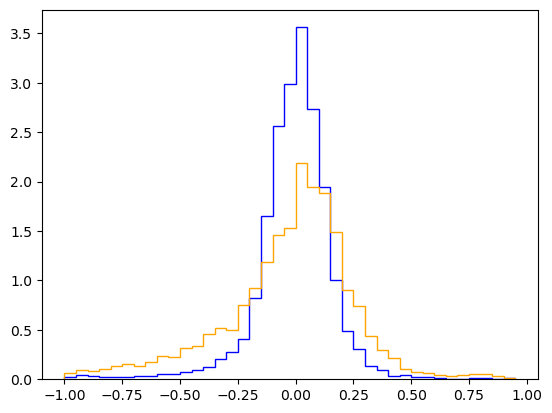

In [41]:
bins2=(np.array(range(-20,20))/20)
a=plt.hist(aa,bins2,histtype='step',density=True,color='blue')
a=plt.hist(ee,bins2,histtype='step',density=True,color='orange')

## Sin outliers

In [42]:
ff=Dis_pro(D[(D['P50_all_filter']>21) & (D['P50_all_filter']<=22)])
print('Distribucion fotómetros oscuros (>21 mag) sin outliers')
print('Numero de fotometros : '+str(len(q[(q['mag']>21) & (q['mag']<=22)])))
Q1,Q2,Q3=pd.DataFrame(ff).quantile(0.25)[0],pd.DataFrame(ff).quantile(0.5)[0],pd.DataFrame(ff).quantile(0.75)[0]
print('Desvación: '+str(np.round((Q3-Q1)/(0.67*2),2)))
print('Asimetría: '+str(np.round((Q1+Q3-2*Q2)/(Q3-Q1),2)))

Distribucion fotómetros oscuros (>21 mag) sin outliers
Numero de fotometros : 176
Desvación: 0.12
Asimetría: 0.0


In [43]:
gg=Dis_pro(D[(D['P50_all_filter']>18) & (D['P50_all_filter']<=21)])
print('Distribucion fotómetros luminosos (<21 mag) sin outliers')
print('Numero de fotometros : '+str(len(q[(q['mag']>18) & (q['mag']<=21)])))
Q1,Q2,Q3=pd.DataFrame(gg).quantile(0.25)[0],pd.DataFrame(gg).quantile(0.5)[0],pd.DataFrame(gg).quantile(0.75)[0]
print('Desvación: '+str(np.round((Q3-Q1)/(0.67*2),2)))
print('Asimetría: '+str(np.round((Q1+Q3-2*Q2)/(Q3-Q1),2)))

Distribucion fotómetros luminosos (<21 mag) sin outliers
Numero de fotometros : 148
Desvación: 0.23
Asimetría: -0.16


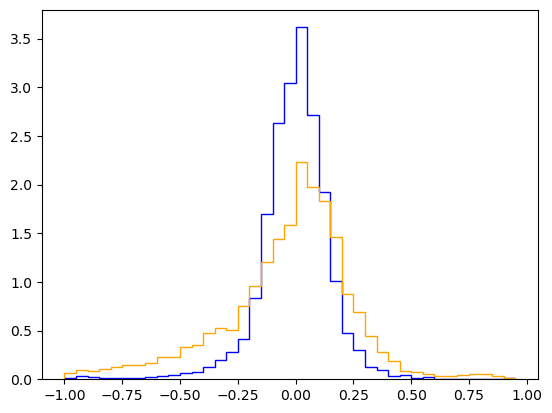

In [44]:
bins2=(np.array(range(-20,20))/20)
a=plt.hist(ff,bins2,histtype='step',density=True,color='blue')
a=plt.hist(gg,bins2,histtype='step',density=True,color='orange')

## Guardado

In [45]:
guar=Igualar_longitud([aa,ee,ff,gg])

[305826, 1135891, 307100, 1117279]


In [46]:
guardar=pd.DataFrame({'Con_outliers_>21':guar[0],'Con_outliers_<21':guar[1],'Sin_outliers_>21':guar[2],'Sin_outliers_<21':guar[3]})
guardar.to_csv(output+'\Figura_5a.csv',index=False)

# Plot QQ

Obtenemos los gráficos Q-Q para comparar con la gaussiana

In [47]:
deciles=np.array(range(1,100))/100

Calculo deciles gaussiana

In [48]:
SS=[]
for sigma in [.1,.2,.3,.3]:
    S=[]
    for i in deciles:
        S=S+[scipy.stats.norm.ppf(i)*sigma]
    SS=SS+[S]

Función para el calculo deciles distrbución promedio

In [49]:
def Deciles(distribucion):
    S=[]
    for i in deciles:
        S=S+[pd.DataFrame(distribucion).quantile(i)[0]]
    return S

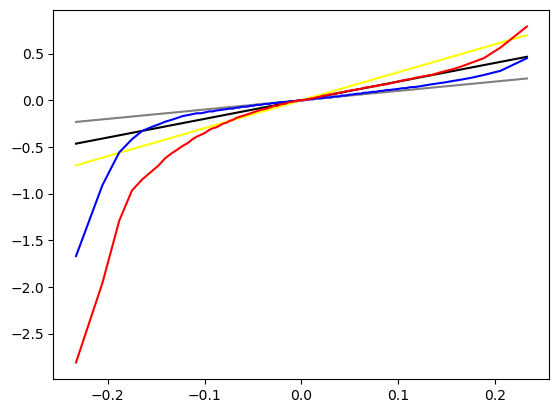

In [50]:
a=plt.plot(SS[0],SS[0],color='gray')
plt.plot(SS[0],SS[1],color='black')
plt.plot(SS[0],SS[2],color='yellow')
plt.plot(SS[0],Deciles(aa),color='blue')
plt.plot(SS[0],Deciles(ee),color='red')

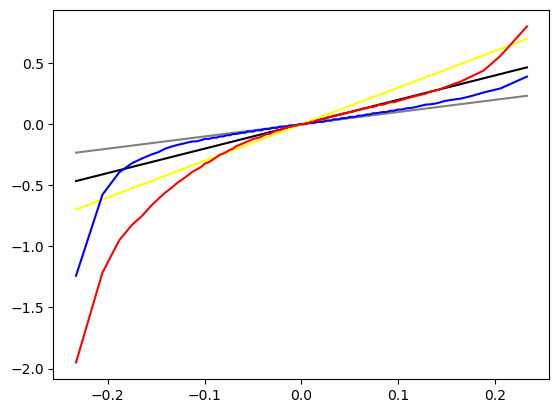

In [51]:
a=plt.plot(SS[0],SS[0],color='gray')
plt.plot(SS[0],SS[1],color='black')
plt.plot(SS[0],SS[2],color='yellow')
plt.plot(SS[0],Deciles(ff),color='blue')
plt.plot(SS[0],Deciles(gg),color='red')

In [52]:
guardar=pd.DataFrame({'Gauss_01':SS[0],'Gauss_02':SS[1],'Gauss_03':SS[2],'Con_outliers_>21':Deciles(aa),'Con_outliers_<21':Deciles(ee),'Sin_outliers_>21':Deciles(ff),'Sin_outliers_<21':Deciles(gg)})
guardar.to_csv(output+'\Figura_5b.csv',index=False)

# Graficos variación RIC

Grafico de la desviación en que se aprecia que los fotómetros con pcoos datos poseeb desvaciones anómalamente bajas al ser muestras insuficientes. Se ga establecido como cota máxima 0.4 de RIC

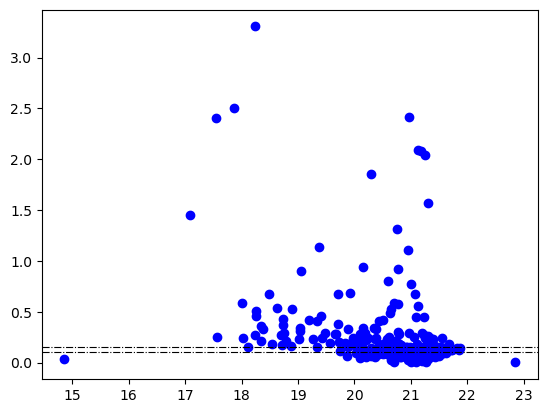

In [53]:
plt.scatter(N_ex_F['P50'],N_ex_F['P75-P25']/(0.67*2),color='blue')
plt.axhline(y=0.1, color="black",linewidth=0.8,linestyle='-.',alpha=1)
plt.axhline(y=0.15, color="black",linewidth=0.8,linestyle='-.',alpha=1)

(0.0, 0.4)

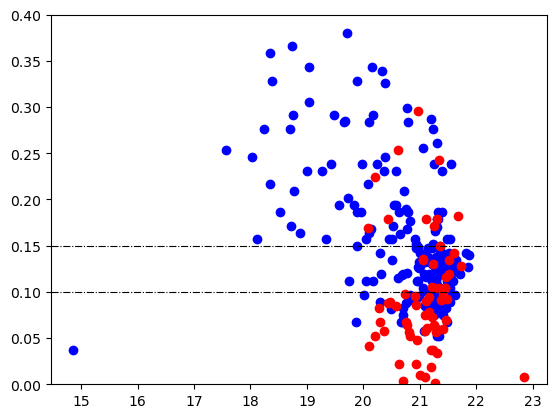

In [54]:
plt.scatter(N_ex_F[N_ex_F['N']>500]['P50'],N_ex_F[N_ex_F['N']>500]['P75-P25']/(0.67*2),color='blue')
plt.scatter(N_ex_F[N_ex_F['N']<500]['P50'],N_ex_F[N_ex_F['N']<500]['P75-P25']/(0.67*2),color='red')
plt.axhline(y=0.1, color="black",linewidth=0.8,linestyle='-.',alpha=1)
plt.axhline(y=0.15, color="black",linewidth=0.8,linestyle='-.',alpha=1)
plt.ylim(0,0.4)

Guardado para el gráfico de la variación del rango intercuartíclio con la magnitud

In [55]:
guardar=pd.DataFrame({'name':N_ex_F[N_ex_F['N']>500].index,'P50':N_ex_F[N_ex_F['N']>500]['P50'].values,'P75-P25':N_ex_F[N_ex_F['N']>500]['P75-P25'].values,'STD':N_ex_F[N_ex_F['N']>500]['STD']})
guardar.to_csv(output+'\Figura_6.csv',index=False)

# Boxplot desviacion

Elaboración del gráfico boxplot de la desviación, Figura 7

In [56]:
Boxplot_RIC=[]
for i in np.array(range(18,22)):
    Boxplot_RIC=Boxplot_RIC+[N_ex_F[(N_ex_F['N']>500) & (N_ex_F['P50']>i) & (N_ex_F['P50']<i+1)]['P75-P25']]

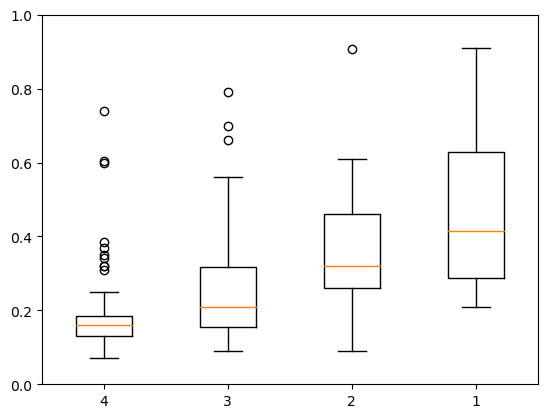

In [57]:
plt.boxplot(Boxplot_RIC)
plt.ylim(0,1)
plt.gca().invert_xaxis()

Guardado

In [58]:
guar=Igualar_longitud(Boxplot_RIC)
guardar=pd.DataFrame({'19-18':guar[0],'20-19':guar[1],'21-20':guar[2],'22-21':guar[3]})
guardar.to_csv(output+'\Figura_7.csv',index=False)

[20, 25, 66, 137]


# ASIMETRÍA

Elaboración del gráfico de los boxplot de la asimetría, Figura 8

In [59]:
Boxplot_Asimetria=[]
for i in np.array(range(18,22)):
    Boxplot_Asimetria=Boxplot_Asimetria+[N_ex_F[(N_ex_F['N']>500) & (N_ex_F['P50']>i) & (N_ex_F['P50']<i+1)]['Asimetria']]

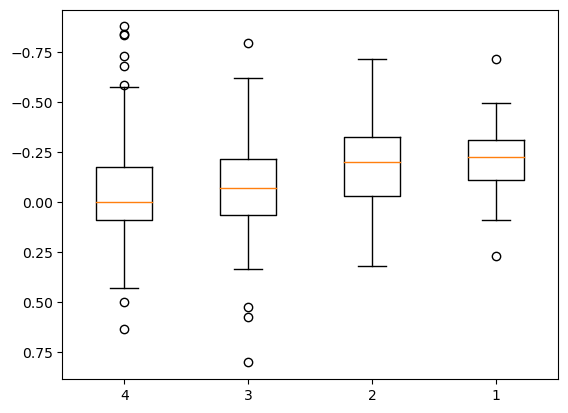

In [60]:
plt.boxplot(Boxplot_Asimetria)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

Guardado

In [61]:
guar=Igualar_longitud(Boxplot_Asimetria)
guardar=pd.DataFrame({'19-18':guar[0],'20-19':guar[1],'21-20':guar[2],'22-21':guar[3]})
guardar.to_csv(output+'\Figura_8a.csv',index=False)

[20, 25, 66, 137]


In [62]:
Boxplot_Asimetria_RIC=[]
for i in np.array(range(0,3)):
    Boxplot_Asimetria_RIC=Boxplot_Asimetria_RIC+[N_ex_F[(N_ex_F['N']>500) & (N_ex_F['P75-P25']>i*.1*(0.67*2)) & (N_ex_F['P75-P25']<(i+1)*.1*(0.67*2))]['Asimetria']]

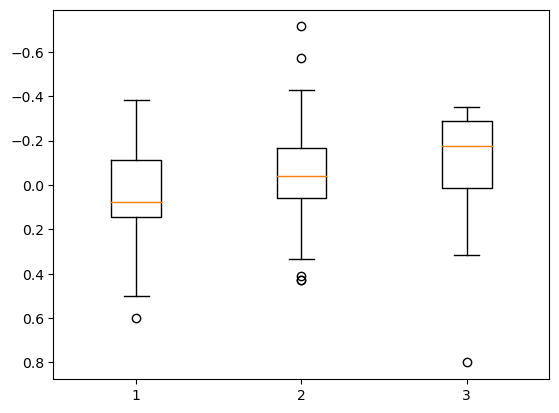

In [63]:
plt.boxplot(Boxplot_Asimetria_RIC)
plt.gca().invert_yaxis()

Guardado

In [64]:
guar=Igualar_longitud(Boxplot_Asimetria_RIC)
guardar=pd.DataFrame({'.1':guar[0],'.2':guar[1],'.3':guar[2]})
guardar.to_csv(output+'\Figura_8b.csv',index=False)

[51, 131, 32]


# Fotómetros filtrados

En esta sección se muestran los diferentes conjuntos que deben ser filtrados según las circustancias obtenidos en este notebook y que son utilizados en notebook Articulo_2

**Fotómetros con menos de 500 datos aplicando filtro de galaxia y zodiacal a todo el rango de magnitudes**

In [65]:
Menores500_pre

{'LPL15_004',
 'LPL15_009',
 'LPL15_011',
 'LPL15_014',
 'LPL15_015',
 'LPL15_017',
 'LPL15_018',
 'LPL15_021',
 'LPL15_022',
 'LPL15_023',
 'LPL15_024',
 'LPL15_025',
 'LPL15_026',
 'LPL15_027',
 'LPL15_029',
 'LPL15_030',
 'LPL15_031',
 'LPL15_032',
 'LPL15_035',
 'LPL15_040',
 'LPL16_001',
 'LPL16_003',
 'LPL1_004',
 'LPL1_009',
 'LPL1_010',
 'LPL1_023',
 'LPL1_049',
 'LPL2_003',
 'LPL2_004',
 'LPL2_020',
 'LPL2_025',
 'LPL2_026',
 'LPL3_101',
 'LPL3_102',
 'LPL3_103',
 'LPL3_106',
 'LPL3_112',
 'LPL3_114',
 'LPL3_118',
 'LPL3_121',
 'LPL3_123',
 'LPL3_125',
 'LPL4_103',
 'LPL4_107',
 'LPL4_114',
 'LPL4_115',
 'LPL4_116',
 'LPL5_112',
 'LPL8_005',
 'LW_374',
 'LW_391',
 'LW_397',
 'SG_088',
 'SG_226',
 'stars201',
 'stars218',
 'stars238',
 'stars250',
 'stars258',
 'stars259',
 'stars262',
 'stars275',
 'stars315',
 'stars337',
 'stars34',
 'stars355',
 'stars379',
 'stars384',
 'stars387',
 'stars4',
 'stars464',
 'stars465',
 'stars467',
 'stars490',
 'stars498',
 'stars517',
 's

**Fotómetros con menos de 500 datos aplicando filtro de galaxia y zodiacal solo a magnitudes oscuras**

In [66]:
Menores500

{'LPL15_004',
 'LPL15_009',
 'LPL15_011',
 'LPL15_014',
 'LPL15_015',
 'LPL15_017',
 'LPL15_018',
 'LPL15_021',
 'LPL15_022',
 'LPL15_023',
 'LPL15_024',
 'LPL15_025',
 'LPL15_026',
 'LPL15_027',
 'LPL15_029',
 'LPL15_030',
 'LPL15_035',
 'LPL16_001',
 'LPL16_003',
 'LPL1_004',
 'LPL1_009',
 'LPL1_010',
 'LPL1_023',
 'LPL1_049',
 'LPL2_003',
 'LPL2_004',
 'LPL2_020',
 'LPL2_025',
 'LPL2_026',
 'LPL3_101',
 'LPL3_102',
 'LPL3_106',
 'LPL3_112',
 'LPL3_114',
 'LPL3_118',
 'LPL3_121',
 'LPL3_123',
 'LPL3_125',
 'LPL4_103',
 'LPL4_107',
 'LPL5_112',
 'LPL8_005',
 'LW_374',
 'LW_391',
 'LW_397',
 'SG_088',
 'SG_226',
 'stars218',
 'stars258',
 'stars259',
 'stars262',
 'stars315',
 'stars337',
 'stars34',
 'stars355',
 'stars379',
 'stars384',
 'stars387',
 'stars464',
 'stars465',
 'stars467',
 'stars490',
 'stars498',
 'stars517',
 'stars554',
 'stars609',
 'stars654',
 'stars662',
 'stars665',
 'stars773',
 'stars774',
 'stars788',
 'stars791',
 'stars983'}

15 fotómetros pasan de ser filtrados a no serlo, aplicando solo el filtro a zonas oscuras

In [67]:
len(Menores500_pre)-len(Menores500)

15

**Fotómetros con más de 500 datos (filtro de galaxia y zodiacal solo a oscuros) no filtrados en cuento número, pero con un RIC excesivamente elevado (>0.4)**

In [68]:
set(N_ex_F[(N_ex_F['N']>500) & (N_ex_F['P75-P25']>=.3999)]['name'])

{'LPL15_032',
 'LPL15_040',
 'LPL3_103',
 'LPL3_113',
 'LPL3_116',
 'LPL4_101',
 'LPL4_115',
 'LPL4_116',
 'LPL5_012',
 'LPL5_109',
 'LW_385',
 'SG_219',
 'SG_229',
 'SG_230',
 'UEX1_001',
 'stars231',
 'stars238',
 'stars243',
 'stars271',
 'stars275',
 'stars290',
 'stars36',
 'stars46',
 'stars47',
 'stars473',
 'stars474',
 'stars51',
 'stars529',
 'stars531',
 'stars60',
 'stars603',
 'stars610',
 'stars651',
 'stars652',
 'stars653',
 'stars671',
 'stars676',
 'stars71',
 'stars716',
 'stars726',
 'stars75',
 'stars76'}

# Histograma ideal

Elaboración del gráfico del histograma ideal, Figura 9

P50 stars2: 20.79 mag
P50 stars47: 18.35 mag


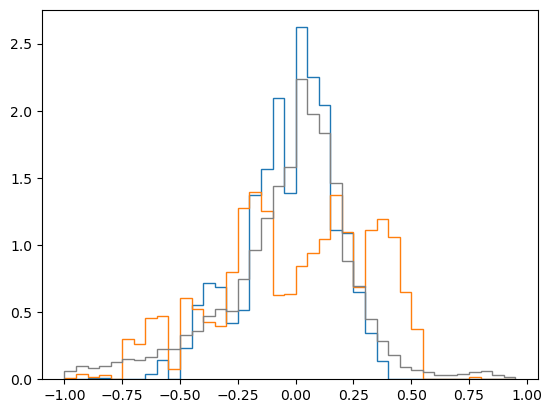

In [69]:
mediana_1=data_3[(data_3['name']=='stars2')].median(numeric_only=True)['mag']
print('P50 stars2: '+ str(mediana_1)+' mag')
a1=data_3[(data_3['name']=='stars2')]['mag']-mediana_1
a=plt.hist(a1,bins2,histtype='step',density=True)

mediana_2=data_3[(data_3['name']=='stars47')].median(numeric_only=True)['mag']
print('P50 stars47: '+ str(mediana_2)+' mag')
b1=data_3[(data_3['name']=='stars47')]['mag']-mediana_2
b=plt.hist(b1,bins2,histtype='step',density=True)

c1=gg
c=plt.hist(c1,bins2,histtype='step',density=True,color='gray')

In [70]:
guar=Igualar_longitud([a1,b1,c1])
guardar=pd.DataFrame({'Promedio':guar[2],'stars2':guar[0],'stars47':guar[1]})
guardar.to_csv(output+'/Figura_9.csv',index=False)

[4958, 8101, 1117279]
